In [1]:
import json
import glob
from os import listdir
from os.path import isfile, join
import os.path as osp
import copy
import os
import pickle
from datetime import datetime
import random
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.filtering.log.attributes import attributes_filter
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv
from torch_geometric.nn import GATv2Conv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def nextplot(force=False):
    """Start a new plot.

    In a notebook (or if `force=True`), create a new figure. Otherwise (e.g, in
    IPython), clear the current figure.

    """
    inNotebook = "IPKernelApp" in get_ipython().config
    if force or inNotebook:
        plt.figure()  # this creates a new plot
    else:
        plt.clf()  # and this clears the current one

### final evaluation for BINet

In [37]:
# define anomaly ratio function
def cut_ratio_func (scores, max_ratio):
    all_cases = len(scores)
    temp_df = scores.loc[scores['max_ratio'] > max_ratio]
    suspicious_cases = len(temp_df)
    ratio = suspicious_cases/all_cases
    return ratio

In [38]:
# define anomaly ratio function
def second_derivative (scores, max_ratio, omega):
    first_anomaly_ratio = cut_ratio_func(scores, max_ratio-omega)
    second_anomaly_ratio = cut_ratio_func(scores, max_ratio)
    third_anomaly_ratio = cut_ratio_func(scores, max_ratio+omega)
    second_der = (first_anomaly_ratio-2*second_anomaly_ratio+third_anomaly_ratio)/np.power(omega,2)
    return second_der

In [343]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\large-thirty\large-0.3-1.csv'
anomaly_scores_path = r'D:\Final master thesis evaluation\large-thirty\binet_loss.pt'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
validation_csv = label_csv.loc[label_csv['case_id'] > 9000]
validation_csv = validation_csv.loc[label_csv['case_id'] < 12001]
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
test_csv.head(1)

,case_id,label
12000,12001,normal


In [344]:
loss_df = pd.read_pickle(anomaly_scores_path)
loss_df.head()

,case_id,max_ratio,label
0,12001,3.625124,normal
1,12002,4.015330,normal
2,12003,3.464501,normal
3,12004,3.794530,normal
4,12005,31.610479,"{'anomaly': 'Insert', 'attr': {'indices': [4, ..."


In [358]:
suspicious_csv = loss_df.loc[loss_df['max_ratio'] > 32]
print(len(suspicious_csv))

0


In [359]:
omega = 20
alpha_low = 2
alpha_high = 32
domain_list = []
for i in range (1,omega+1):
    domain_list.append(alpha_low+i/omega*(alpha_high-alpha_low))
print(domain_list)
second_derivative_list = []
for alpha in domain_list:
    sec_der = second_derivative (loss_df, alpha, omega)
    second_derivative_list.append(sec_der)
print(second_derivative_list)

[3.5, 5.0, 6.5, 8.0, 9.5, 11.0, 12.5, 14.0, 15.5, 17.0, 18.5, 20.0, 21.5, 23.0, 24.5, 26.0, 27.5, 29.0, 30.5, 32.0]
[-0.001223333333333333, 0.0018458333333333332, 0.001845, 0.0018416666666666664, 0.0018375, 0.0017333333333333335, 0.0012183333333333332, 0.0012183333333333332, 0.00122, 0.0012216666666666667, 0.0012266666666666667, 0.0012283333333333332, 0.00123, 0.0011983333333333334, -0.0006208333333333333, -0.0006175, -0.0006158333333333333, -0.0006041666666666666, -0.0005633333333333333, 0.0006416666666666667]


In [360]:
suspicious_csv = loss_df.loc[loss_df['max_ratio'] > 5.0]
result = pd.merge(suspicious_csv, test_csv, on=["case_id"])
false_positve_df = result.loc[result['label_x'] == 'normal']
anomalies = test_csv.loc[test_csv['label'] != 'normal']
positives = len(suspicious_csv)
negatives = len(test_csv)-positives
false_positives =len(false_positve_df)
true_positives = positives - false_positives
false_negatives = len(anomalies) - true_positives
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
fhalf_score = 5/4*precision*recall/(1/4*precision+recall)
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [precision, recall, f1_score, fhalf_score, macro_f1_score]  
print(best_cut)

[1.0, 0.8711864406779661, 0.9311594202898551, 0.9712773998488283, 0.9524581631836015]


### AUPRC, and Nayman

In [498]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\exp1\large-0.1-1.csv'
gat_path = r'D:\Final master thesis evaluation\exp2\bestgatmodl_test_loss.pt'
binet_path = r'D:\Final master thesis evaluation\exp2\binet_loss.pt'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
test_csv.head(1)

,case_id,label
12000,12001,normal


In [499]:
temp_gat = pd.read_pickle(gat_path)
loss_gat = temp_gat.copy()
loss_gat['Loss'] = (loss_gat['Loss'] - loss_gat['Loss'].min()) / (loss_gat['Loss'].max() - loss_gat['Loss'].min())
loss_gat["case_id"] = pd.to_numeric(loss_gat["case_id"])
result_gat = pd.merge(loss_gat, test_csv, on=["case_id"])
sorted_gat = result_gat.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_gat.head()

,case_id,Loss,label
0,14889,1.000000,"{'anomaly': 'Rework', 'attr': {'inserted': [{'..."
1,14051,0.959643,"{'anomaly': 'Early', 'attr': {'shift_from': 2,..."
2,14247,0.951132,"{'anomaly': 'Early', 'attr': {'shift_from': 2,..."
3,12198,0.921277,"{'anomaly': 'Rework', 'attr': {'inserted': [{'..."
4,13270,0.916007,"{'anomaly': 'Rework', 'attr': {'inserted': [{'..."


In [500]:
loss_binet = pd.read_pickle(binet_path)
sorted_binet = loss_binet.sort_values(by=['max_ratio'], ascending = False, ignore_index = True)
sorted_binet.head()

,case_id,max_ratio,label
0,14313,62.726774,"{'anomaly': 'Rework', 'attr': {'inserted': [{'..."
1,12868,62.726767,"{'anomaly': 'Rework', 'attr': {'inserted': [{'..."
2,14981,62.726763,"{'anomaly': 'Insert', 'attr': {'indices': [6, ..."
3,13914,62.726763,"{'anomaly': 'Insert', 'attr': {'indices': [4, ..."
4,14016,62.726759,"{'anomaly': 'Rework', 'attr': {'inserted': [{'..."


In [485]:
gat_list = sorted_gat['label'].tolist()
binet_list = sorted_binet['label'].tolist()

gat_predictions = []
binet_predictions = []

for j in range (len(gat_list)):
    if gat_list[j] == 'normal':
        gat_predictions.append(0)
    else:
        gat_predictions.append(1)
for j in range (len(binet_list)):
    if binet_list[j] == 'normal':
        binet_predictions.append(0)
    else:
        binet_predictions.append(1)

gat_array = np.array(gat_predictions)
binet_array = np.array(binet_predictions)
        
gat_auprc  = 0
gat_precision = []
gat_recall = []
prev_precision = 1
prev_recall = 0
for j in range (len(gat_list)):
    current_alarms = gat_array[0:j+1]
    current_normals = gat_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    gat_precision.append(precision)
    gat_recall.append(recall)
    if precision == prev_precision:
        gat_auprc += precision*(recall-prev_recall)
    prev_precision = precision
    prev_recall = recall

binet_auprc  = 0
binet_precision = []
binet_recall = []
prev_precision = 1
prev_recall = 0
for j in range (len(binet_list)):
    current_alarms = binet_array[0:j+1]
    current_normals = binet_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    binet_precision.append(precision)
    binet_recall.append(recall)
    if precision == prev_precision:
        binet_auprc += precision*(recall-prev_recall)
    prev_precision = precision
    prev_recall = recall
    
print(gat_auprc)
print(binet_auprc)

0.29333333333333333
0.8488888888888889


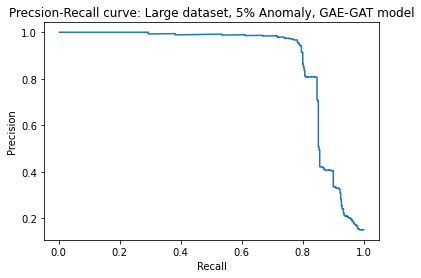

In [483]:
y_axis = np.array(gat_precision)
x_axis = np.array(gat_recall)
nextplot()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precsion-Recall curve: Large dataset, 5% Anomaly, GAE-GAT model")
plt.plot(x_axis, y_axis)
plt.savefig("AUPRC-GAT", dpi=1200)
plt.show()

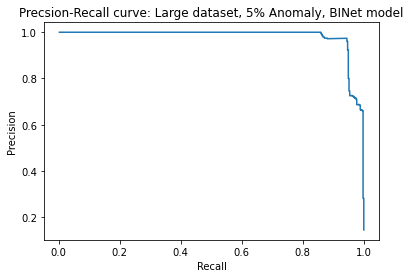

In [449]:
y_axis = np.array(binet_precision)
x_axis = np.array(binet_recall)
nextplot()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precsion-Recall curve: Large dataset, 5% Anomaly, BINet model")
plt.plot(x_axis, y_axis)
plt.savefig("AUPRC-BINet", dpi=1200)
plt.show()

In [504]:
gat_list = sorted_gat['label'].tolist()
binet_list = sorted_binet['label'].tolist()

gat_predictions = []
binet_predictions = []

for j in range (len(gat_list)):
    if gat_list[j] == 'normal':
        gat_predictions.append(0)
    else:
        gat_predictions.append(1)
for j in range (len(binet_list)):
    if binet_list[j] == 'normal':
        binet_predictions.append(0)
    else:
        binet_predictions.append(1)

gat_array = np.array(gat_predictions)
binet_array = np.array(binet_predictions)
alpha_max = 0.2   

for j in range (len(gat_list)):
    current_alarms = gat_array[0:j+1]
    current_normals = gat_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    if false_positives > alpha_max*positives:
        break
print(false_negatives)

for j in range (len(binet_list)):
    current_alarms = binet_array[0:j+1]
    current_normals = binet_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    if false_positives > alpha_max*positives:
        break    

print(false_negatives)

59
21


### limitations

In [39]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\exp1\large-0.1-1.csv'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp2\bestgatmodl_test_loss.pt'
anomaly_scores_path2 = r'D:\Final master thesis evaluation\exp2\binet_loss.pt'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
loss_df = pd.read_pickle(anomaly_scores_path)
# normalize anomaly scores
normalized_loss_df = loss_df.copy()
normalized_loss_df['Loss'] = (normalized_loss_df['Loss'] - normalized_loss_df['Loss'].min()) / (normalized_loss_df['Loss'].max() - normalized_loss_df['Loss'].min())
# sort the normalized scores
sorted_loss = normalized_loss_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)
test_csv.head(1)

,case_id,label
12000,12001,normal


In [27]:
sorted_loss.head(1)

,case_id,Loss
0,14889,1.0


In [18]:
normal_csv =  test_csv.loc[test_csv['label'] == 'normal']
anomalous_csv = test_csv.loc[test_csv['label'] != 'normal']
insert_csv = anomalous_csv.loc[anomalous_csv['label'].str.contains("Insert")]
attribute_csv = anomalous_csv.loc[anomalous_csv['label'].str.contains("Attribute")]
rework_csv = anomalous_csv.loc[anomalous_csv['label'].str.contains("Rework")]
skip_csv = anomalous_csv.loc[anomalous_csv['label'].str.contains("SkipSequence")]
late_csv = anomalous_csv.loc[anomalous_csv['label'].str.contains("Late")]
early_csv = anomalous_csv.loc[anomalous_csv['label'].str.contains("Early")]
print(len(normal_csv))
print(len(insert_csv))
print(len(attribute_csv))
print(len(rework_csv))
print(len(skip_csv))
print(len(late_csv))
print(len(early_csv))

2566
77
60
78
82
73
64


In [21]:
loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(loss_df, test_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score]    
print(best_cut)

first false positive: 284
[370, 0.9973045822102425, 0.8525345622119815, 0.919254658385093, 0.9756561430201598, 0.9996102883865939, 0.9874879692011549, 0.9533713137931239]


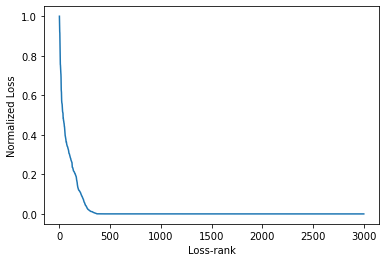

In [23]:
loss_list = sorted_loss['Loss'].tolist()
y_axis = np.array(loss_list)
x_axis = np.arange(len(test_csv))
nextplot()
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y_axis)
plt.show()

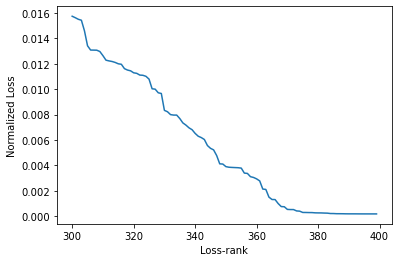

In [24]:
y2_axis = y_axis[300:400]
x_axis = np.arange(300,400)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

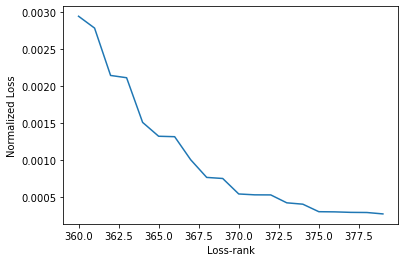

In [25]:
y2_axis = y_axis[360:380]
x_axis = np.arange(360,380)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

In [26]:
j= 370
current_alarms = prediction_array[0:j+1]
current_normals = prediction_array[j+1:]
positives = j+1
true_positives = np.sum(current_alarms)
false_positives = positives - true_positives
negatives = 3000 - positives
false_negatives = np.sum(current_normals)
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
best_score = f1_score
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
            f1_score_on_normal, macro_f1_score]    
print(best_cut)
print('false positives', false_positives)

[370, 0.9973045822102425, 0.8525345622119815, 0.919254658385093, 0.9756561430201598, 0.9996102883865939, 0.9874879692011549, 0.9533713137931239]
false positives 1


In [36]:
gat_alarm_temp = sorted_loss['case_id'].tolist()
gat_alarm_temp2 = list(map(int, gat_alarm_temp))
gat_alarm_list = gat_alarm_temp2[:370]
insert_list = insert_csv['case_id'].tolist()
attribute_list = attribute_csv['case_id'].tolist()
rework_list = rework_csv['case_id'].tolist()
skip_list = skip_csv['case_id'].tolist()
late_list = late_csv['case_id'].tolist()
early_list = early_csv['case_id'].tolist()
found_insert = list(set(gat_alarm_list).intersection(insert_list))
found_attribute = list(set(gat_alarm_list).intersection(attribute_list))
found_rework = list(set(gat_alarm_list).intersection(rework_list))
found_skip = list(set(gat_alarm_list).intersection(skip_list))
found_late = list(set(gat_alarm_list).intersection(late_list))
found_early = list(set(gat_alarm_list).intersection(early_list))
print(len(found_insert))
print(len(found_attribute))
print(len(found_rework))
print(len(found_skip))
print(len(found_late))
print(len(found_early))

77
4
78
77
72
61


In [40]:
loss_binet_df = pd.read_pickle(anomaly_scores_path2)
omega = 20
alpha_low = 2
alpha_high = 32
domain_list = []
for i in range (1,omega+1):
    domain_list.append(alpha_low+i/omega*(alpha_high-alpha_low))
print(domain_list)
second_derivative_list = []
for alpha in domain_list:
    sec_der = second_derivative (loss_binet_df, alpha, omega)
    second_derivative_list.append(sec_der)
print(second_derivative_list)

[3.5, 5.0, 6.5, 8.0, 9.5, 11.0, 12.5, 14.0, 15.5, 17.0, 18.5, 20.0, 21.5, 23.0, 24.5, 26.0, 27.5, 29.0, 30.5, 32.0]
[-0.0012900000000000001, 0.00217, 0.00217, 0.0021666666666666666, 0.0021658333333333334, 0.002163333333333333, 0.0021616666666666668, 0.002160833333333333, 0.002160833333333333, 0.002160833333333333, 0.002160833333333333, 0.002160833333333333, 0.00216, 0.002116666666666667, -7.500000000000007e-06, -7.500000000000007e-06, -5.833333333333385e-06, 6.938893903907229e-20, 2.499999999999933e-06, 5.833333333333315e-06]


In [43]:
suspicious_csv = loss_binet_df.loc[loss_binet_df['max_ratio'] > 5.0]
binet_alarm_list = suspicious_csv['case_id'].tolist()
found_insert2 = list(set(binet_alarm_list).intersection(insert_list))
found_attribute2 = list(set(binet_alarm_list).intersection(attribute_list))
found_rework2 = list(set(binet_alarm_list).intersection(rework_list))
found_skip2 = list(set(binet_alarm_list).intersection(skip_list))
found_late2 = list(set(binet_alarm_list).intersection(late_list))
found_early2 = list(set(binet_alarm_list).intersection(early_list))
print(len(found_insert2))
print(len(found_attribute2))
print(len(found_rework2))
print(len(found_skip2))
print(len(found_late2))
print(len(found_early2))

77
9
78
81
73
64
